# How to load and Save models in Tensorflow

In this notebook, we shall perform Transfer learning on a Dogs Vs Cats dataset, Save our model and load it back up to perform predictions.

## Goals 

- Saving models in HDF5 format for Keras <br>
- Saving models in the Tensorflow sSavedModel format <br>
- Loading model <br>
- Download models to Local Disk

## Import Relevant Libraries

In [1]:
#Standard libs
import time 
import numpy as np
import matplotlib.pylab as plt

#Tensorflow libs
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers


## Load Data ( Cats and Dogs )

In [2]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

## Reformat Images  

We need to reformat all our images to a resolution expected by the MobileNet model (224,224)

In [3]:
def format_image(image, label):
  # `hub` image modules exepct their data normalized to the [0,1] range.
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return  image, label

num_examples = info.splits['train'].num_examples

BATCH_SIZE = 32
IMAGE_RES = 224

train_batches      = train_examples.cache().shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)

## Transfer Learning with Tensorflow Hub 

In [4]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

### Freeze the variables in the model 

This is done so the training only modifies the final classifier layer

In [5]:
feature_extractor.trainable = False

## Attach a classification head

Let us wrap the hub layer in a tf.keras.sequential model, and add a new classification layer

In [6]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


## Train the model 

Over here , we compile the model and then fit it

In [7]:
#Compiling....
model.compile(
  optimizer='adam', 
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 3

#Fitting....
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/3
582/582 [==============================] - 547s 940ms/step - loss: 0.0514 - accuracy: 0.9831 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/3
582/582 [==============================] - 513s 882ms/step - loss: 0.0317 - accuracy: 0.9898 - val_loss: 0.0297 - val_accuracy: 0.9905
Epoch 3/3
582/582 [==============================] - 518s 890ms/step - loss: 0.0255 - accuracy: 0.9914 - val_loss: 0.0331 - val_accuracy: 0.9886


## Check the predictions

First, we need to get an ordered list of class names

In [8]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

Run an image batch through the model and convert the indices to class names.

In [9]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'dog',
       'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat',
       'dog', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog',
       'dog', 'cat', 'dog', 'dog', 'cat'], dtype='<U3')

Check true lables and predicted ones

In [10]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 1 1 0 0 1 0 0 1 1 0 0 0 1 0 0 1 0 1 0 1 1 0 1 0 1 1 1 0 1 1 0]
Predicted labels:  [0 1 1 0 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1 0 1 1 0 1 0 1 1 1 0 1 1 0]


## Lets Plot our Predictions 

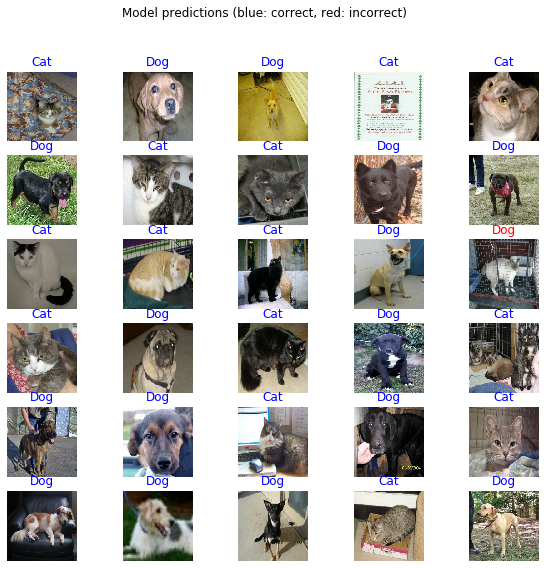

In [11]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

## Save as Keras .h5 model

Now that we've trained the model, we can save it as an HDF5 file, which is the format used by Keras. Our HDF5 file will have the extension '.h5', and it's name will correpond to the current time stamp.

In [12]:
t = time.time()

export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

./1594188935.h5


In [13]:
!ls

 Pokédex (ポケモン図鑑 Pokemon Zukan).ipynb
1. TensorFlow_MNIST_Width_Solution.ipynb
1.02. Multiple linear regression.csv
1.04. Real-life example.csv
1593768349.h5
1594188935.h5
2. TensorFlow_MNIST_Depth_Solution.ipynb
3. TensorFlow_MNIST_Width_and_Depth_Solution.ipynb
4. TensorFlow_MNIST_Activation_functions_Part_1_Solution.ipynb
5. TensorFlow_MNIST_Activation_functions_Part_2_Solution.ipynb
6. TensorFlow_MNIST_Batch_size_Part_1_Solution.ipynb
7. TensorFlow_MNIST_Batch_size_Part_2_Solution.ipynb
8. TensorFlow_MNIST_Learning_rate_Part_1_Solution.ipynb
9. TensorFlow_MNIST_Learning_rate_Part_2_Solution.ipynb
A Simple Example of Clustering - Exercise.ipynb
A Simple Example of Clustering - Solution.ipynb
Absenteeism Case - Integration & Deployment of the 'absenteeism_module'.ipynb
Absenteeism Case - Machine Learning.ipynb
Absenteeism Case - Preprocessing.ipynb
Absenteeism Exercise - Preprocessing - ChP - df_date_reason_mod.ipynb
Absenteeism Exercise - Removing the Date Column - SOLUTION.ipynb
Ab

## Quick info !

You can later recreate the same model from this file, even if you no longer have access to the code that created the model.<br><br>

This file includes:<br>

The model's architecture <br>
The model's weight values (which were learned during training) <br>
The model's training config (what you passed to compile), if any <br>
The optimizer and its state, if any (this enables you to restart training where you left off) <br>

## How to Load the Keras .h5 Model 

We will now create a new model called "reloaded" where we will load our existing model into.<br><br>
-A file path is required <br>
-A custom objects parameter is also needed <br>
NB : this parameter tells Keras how to load the hub.Keras Later from the feature_extractor we used for transfer learning.

In [14]:
reloaded = tf.keras.models.load_model(
  export_path_keras, 
  # `custom_objects` tells keras how to load a `hub.KerasLayer`
  custom_objects={'KerasLayer': hub.KerasLayer})

reloaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


## Lets compare with the old model 

In [15]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [16]:
(abs(result_batch - reloaded_result_batch)).max()

0.0

## Export as SavedModel 

This allows us to export the entire model to the TensorFlow SavedModel format.
Thus it contains the entire TensorFlow program including weights and computation.<br>
This becomes very useful for sharing and deploying (with TFLite, TensorFlow.js, TensorFlow Serving, or TFHub)<br><br>

Contains: <br><br>
-A TensorFlow checkpoint containing the model weights.<br>
-A SavedModel proto containing the underlying Tensorflow graph. Separate graphs are saved for prediction (serving), train, and evaluation. If the model wasn't compiled before, then only the inference graph gets exported.<br>
-The model's architecture config, if available.


In [17]:
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)

tf.saved_model.save(model, export_path_sm)

./1594191040
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: ./1594191040/assets


INFO:tensorflow:Assets written to: ./1594191040/assets


In [18]:
!ls {export_path_sm}

assets         saved_model.pb variables


## Reload SavedModel 

In [19]:
reloaded_sm = tf.saved_model.load(export_path_sm)

## Predict with Reloaded_sm Model 

In [21]:
reload_sm_result_batch = reloaded_sm(image_batch, training=False).numpy()

We can check that the reloaded SavedModel and the previous model give the same result.

In [23]:
(abs(result_batch - reload_sm_result_batch)).max()

0.0

## How to Download your model 

download the SavedModel to your local disk by creating a zip file. We wil use the -r (recursice) option to zip all subfolders.

In [24]:
!zip -r model.zip {export_path_sm}

  adding: 1594191040/ (stored 0%)
  adding: 1594191040/variables/ (stored 0%)
  adding: 1594191040/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: 1594191040/variables/variables.index (deflated 78%)
  adding: 1594191040/saved_model.pb (deflated 92%)
  adding: 1594191040/assets/ (stored 0%)


In [25]:
!ls

 Pokédex (ポケモン図鑑 Pokemon Zukan).ipynb
1. TensorFlow_MNIST_Width_Solution.ipynb
1.02. Multiple linear regression.csv
1.04. Real-life example.csv
1593768349.h5
1594188935.h5
1594191040
2. TensorFlow_MNIST_Depth_Solution.ipynb
3. TensorFlow_MNIST_Width_and_Depth_Solution.ipynb
4. TensorFlow_MNIST_Activation_functions_Part_1_Solution.ipynb
5. TensorFlow_MNIST_Activation_functions_Part_2_Solution.ipynb
6. TensorFlow_MNIST_Batch_size_Part_1_Solution.ipynb
7. TensorFlow_MNIST_Batch_size_Part_2_Solution.ipynb
8. TensorFlow_MNIST_Learning_rate_Part_1_Solution.ipynb
9. TensorFlow_MNIST_Learning_rate_Part_2_Solution.ipynb
A Simple Example of Clustering - Exercise.ipynb
A Simple Example of Clustering - Solution.ipynb
Absenteeism Case - Integration & Deployment of the 'absenteeism_module'.ipynb
Absenteeism Case - Machine Learning.ipynb
Absenteeism Case - Preprocessing.ipynb
Absenteeism Exercise - Preprocessing - ChP - df_date_reason_mod.ipynb
Absenteeism Exercise - Removing the Date Column - SOLUTI